# No recorded hits

The error happens when there is an overlap in $z$.

We create a passive volume made of **water** and **lead**.

In [17]:
import torch
from tomopt.core import X0
from torch import Tensor

def arb_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['water']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

from tomopt.optimisation import PassiveYielder
passives = PassiveYielder([arb_rad_length,arb_rad_length], shuffle=True)

We create a geometry with hodoscopes that overlap in $z$:

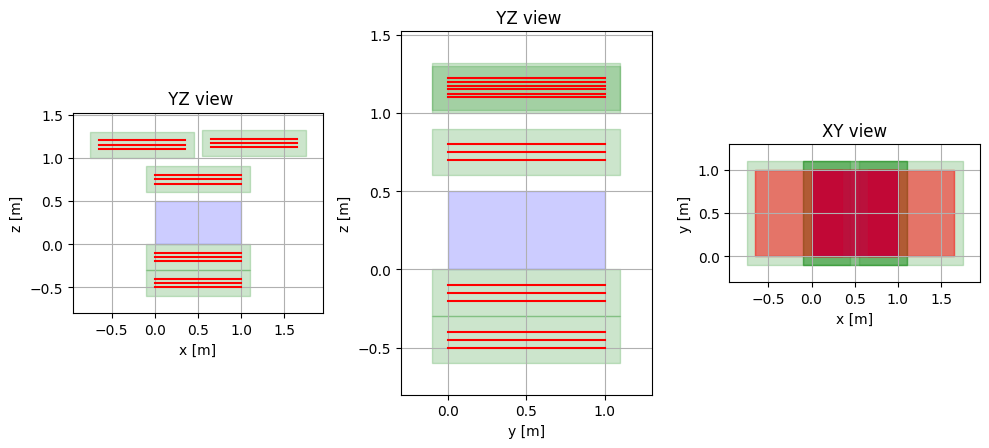

In [18]:
from volume.hodoscope import Hodoscope
from volume.hodoscopelayer import HodoscopeDetectorLayer
from tomopt.volume.layer import PassiveLayer
from tomopt.core import DEVICE
from tomopt.volume import Volume
from torch import nn

def get_z_overlap_hod_config() -> Volume:

    init_xyz_span, xyz_gap = [1.2, 1.2, .3], [.1, .1, .1]
    init_eff, init_res = 0.90, 1e5

    hods = [Hodoscope(init_xyz= [0.5, 0.5, .9], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res), 
            Hodoscope(init_xyz= [1.15, .5, 1.32], 
            init_xyz_span = init_xyz_span, 
            xyz_gap = xyz_gap, 
            eff = init_eff,
            res = init_res), 
                      Hodoscope(init_xyz= [-.15, .5, 1.3], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res),
                      ]
                    #  ) for xy, z in zip([0.4, 0.8], [.9, 1.3])]

    hod_detector_above = HodoscopeDetectorLayer(pos = 'above', 
                                                lw = Tensor([2,2]), 
                                                z = 1., size = 0.5, 
                                                hodoscopes = hods)

    hods = [Hodoscope(init_xyz= [.5, .5, z], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res
                     ) for z in [0.0,-0.3]]
    
    hod_detector_below = HodoscopeDetectorLayer(pos = 'below', 
                                                lw = Tensor([1,1]), 
                                                z = 1., size = 0.5, 
                                                hodoscopes = hods)

    def get_layers(hod_layers):
        layers = []
        lwh = Tensor([1,1,1])
        size = 0.1
        
        layers.append(hod_layers[0])
        for z in [0.7,0.6,0.5,0.4,0.3]:
            layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
        layers.append(hod_layers[1])

        return nn.ModuleList(layers)
    
    return Volume(get_layers([hod_detector_above, hod_detector_below]))

# Create the volume
volume = get_z_overlap_hod_config()

# Draw volume
from plotting.plotting import draw_volume_2D
draw_volume_2D(volume)

In [19]:
from tomopt.optimisation.callbacks import MuonResampler, ScatterRecord, HitRecord
from tomopt.optimisation import PredHandler, ScatterRecord, HitRecord, ScatterAngleRecord
from optimisation.hodoscope_volume_wrapper import HodoscopeVolumeWrapper
from functools import partial
from tomopt.optimisation import VoxelX0Loss

In [20]:
wrapper = HodoscopeVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xyz_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VoxelX0Loss(target_budget=20, cost_coef=None))

# Set up wrapper
sr = ScatterRecord()
hr = HitRecord()
sar = ScatterAngleRecord()

# Run predictions
preds = wrapper.predict(PassiveYielder([arb_rad_length]), 
                        n_mu_per_volume=500, 
                        mu_bs=500, 
                        pred_cb=PredHandler(), 
                        cbs=[MuonResampler(), sr, hr, sar])

filter_muons 0
keep mask =  tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True

TypeError: nan_to_num(): argument 'input' (position 1) must be Tensor, not NoneType

The error happens when there is an overlap in $z$. 

Let's **manually run** the **`wrapper.predict` method** which basicaly does:

```python
    self.fit_params = FitParams(
                n_mu_per_volume=n_mu_per_volume,
                mu_bs=mu_bs,
                cbs=cbs,
                tst_passives=passives,
                state="test",
                cb_savepath=cb_savepath,
                device=self.device,
            )

    self._scan_volumes(self.fit_params.tst_passives)

return pred_cb.get_preds()
```

With `_scan_volumes` defined as:

```python
self.volume.load_rad_length(passive, target)
self._scan_volume()
```

and `_scan_volumes` defined as:
```python

muon_bar = progress_bar(range(self.fit_params.n_mu_per_volume // self.fit_params.mu_bs))
for _ in muon_bar:
    self.fit_params.mu = MuonBatch(self.mu_generator(self.fit_params.mu_bs), init_z=self.volume.h, device=self.fit_params.device)
    # On muon batch begin
    self.volume(self.fit_params.mu)
    self.fit_params.sb = self.partial_scatter_inferrer(mu=self.fit_params.mu, volume=self.volume)
    # On scatter end
    self.fit_params.volume_inferrer.add_scatters(self.fit_params.sb)
    # On muon batch end

self.fit_params.pred = self.fit_params.volume_inferrer.get_prediction()
```



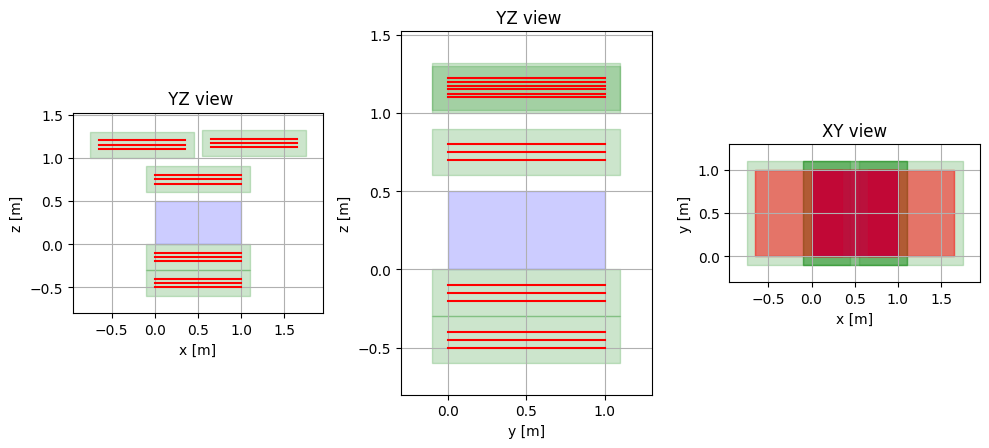

filter_muons 0
keep mask =  tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True

In [21]:
from volume.hodoscope_init_config import get_standard_hod_config
volume = get_z_overlap_hod_config()

# Plot volume
draw_volume_2D(volume)

# Load radiation length
volume.load_rad_length(arb_rad_length)

# generate muons
from tomopt.muon import MuonGenerator2016, MuonBatch

gen = MuonGenerator2016(x_range=[0.,1.], 
                        y_range=[0.,1.], 
                        theta_range=[0.001, 0.2], 
                        energy_range=[1.,4.])

muons = MuonBatch(xy_p_theta_phi=gen.generate_set(500), init_z = 1.5)

# Propagate muons
volume(muons)

# Get ScatterBatch
from tomopt.inference.scattering import ScatterBatch
sb = ScatterBatch(mu = muons, volume = volume)

In [22]:
# Load each ScatterBatch in the volume inferrer
print("# recorded muon event = ", sb._gen_hits.size()[0])
print("# poca points = ", sb.poca_xyz.size()[0])


# recorded muon event =  492
# poca points =  492


It seems that hits have been recorded properly. Let's have a look:

## I - Muon hits

### A - Generated hits

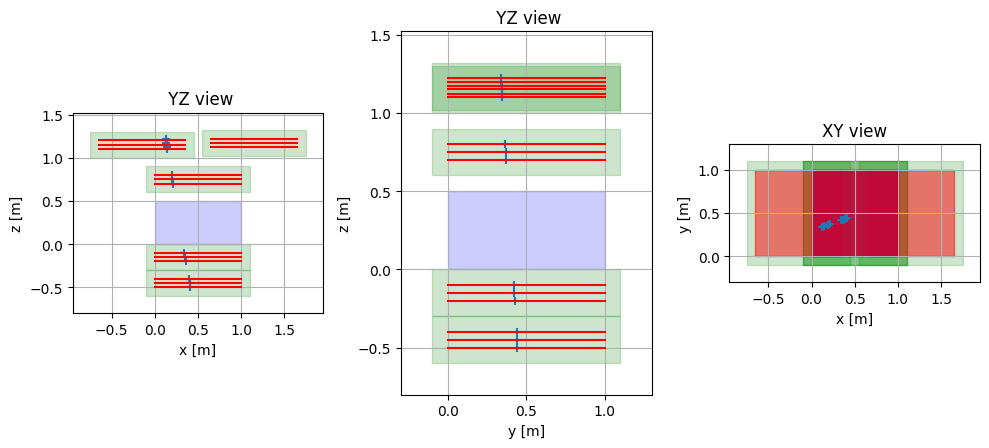

In [23]:
from plotting.plotting import draw_volume_2D
import numpy as np

draw_volume_2D(volume, sb._gen_hits, event = np.random.randint(200))

### B - Reconstructed hits

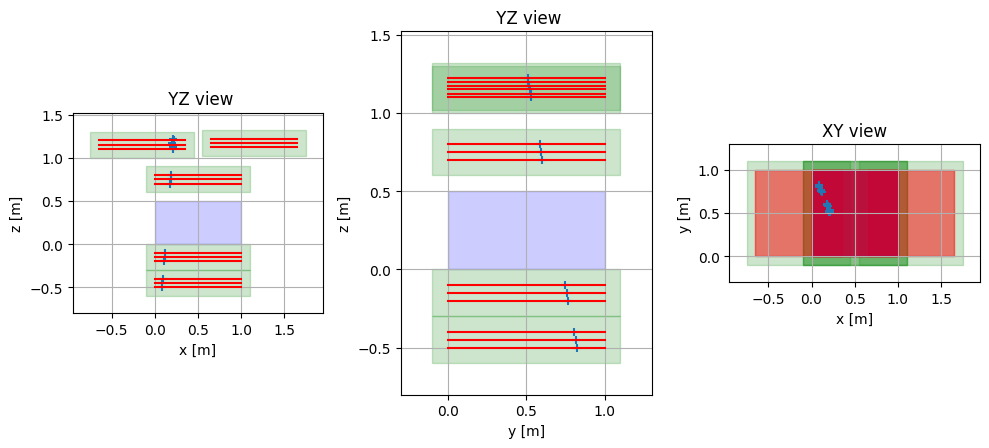

In [24]:
draw_volume_2D(volume, sb._reco_hits, event = np.random.randint(200))

#### Training mode

The hits plotted above were obtain with panels in "training" mode, meaning that the `training` feature of the panels was set to True.

In [25]:
for l in volume.layers:
    if isinstance(l, HodoscopeDetectorLayer):
        for h in l.hodoscopes:
            for p in h.panels:
                print("panel training = {}".format(p.training))


panel training = True
panel training = True
panel training = True
panel training = True
panel training = True
panel training = True
panel training = True
panel training = True
panel training = True
panel training = True
panel training = True
panel training = True
panel training = True
panel training = True
panel training = True


When **training mode** is on, **hits outside** of the **panel's area** are still **recorded**. Looking at the $XZ$ projection on the **A - generated hits** plot, hits associated to the left hodoscope have been recorded even though they are not within the panels area.

Let's try to **set** the panels' **`training` feature to `False`** and see the difference:

In [26]:
for l in volume.layers:
    if isinstance(l, HodoscopeDetectorLayer):
        for h in l.hodoscopes:
            for p in h.panels:
                p.training = False
                print("panel training = {}".format(p.training))


panel training = False
panel training = False
panel training = False
panel training = False
panel training = False
panel training = False
panel training = False
panel training = False
panel training = False
panel training = False
panel training = False
panel training = False
panel training = False
panel training = False
panel training = False


In [27]:
scatter_batches = []


gen = MuonGenerator2016(x_range=[0.,1.], 
                        y_range=[0.,1.], 
                        theta_range=[0.001, 0.2], 
                        energy_range=[1.,4.])

muons = MuonBatch(xy_p_theta_phi=gen.generate_set(500), init_z = 1.5)

# Propagate muons
volume(muons)

# Get ScatterBatch
scatter_batches.append(ScatterBatch(mu = muons, volume = volume))

# Get generated hits
gen_hits = torch.cat([sb._gen_hits for sb in scatter_batches], dim=0)

# Get reconstructed hits
reco_hits = torch.cat([sb._reco_hits for sb in scatter_batches], dim=0)

filter_muons 0
keep mask =  tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True

In [28]:
print("N reco hits = {}, N gen hits = {}".format(reco_hits.size()[0], gen_hits.size()[0]))

N reco hits = 0, N gen hits = 0


When `training` is set to `False`, no hits are recorded !!! This is where the error comes from!!! 

Let's try to understand at which step the muons are removed. Let's do it in another notebook, `scatter_batch_filter_muons_dev.ipynb`